<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Joint contribution](03.01-contributions-evsn.ipynb) | [Contents](Index.ipynb) | [Muscle activations & muscles forces](03.03-muscle-activations-forces.ipynb) >

# EMG

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    random_balanced_design,
    get_spm_cluster,
    ridge_plot
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Read files

In [3]:
project_path = Path("/media/romain/E/Projet_ExpertsNovices/opensim/")

In [4]:
def correct_path(x):
    return Path(
        x.replace("home/laboratoire/mnt/E", "/media/romain/E")
        #         .replace("E:", "/media/romain/E")
        .replace("1_inverse_kinematic", "0_emg")
        .replace(".mot", ".sto")
        .replace("wu_expertsnovicesD_", "")
        .replace("wu_expertsnovicesG_", "")
    )


def parse_conditions(d):
    return d.merge(
        pd.read_csv(project_path / "_conf.csv")[["participant", "group"]].rename(
            columns={"group": "expert"}
        ),
        on="participant",
    ).assign(
        fatigue=lambda x: x["filename"].str[0].astype(int) - 1,
        height=lambda x: x["filename"].str[2].astype("category"),
        mass=lambda x: x["filename"].str[3:5].astype(int),
        filename=lambda x: x["participant"] + "_" + x["filename"],
        participant=lambda x: x["participant"].astype("category"),
    )

In [5]:
LOAD = False
data_filename = project_path.parent / "emg" / "emg.csv"

if LOAD:
    emg = pd.read_csv(
        data_filename, dtype={i: "category" for i in ["participant", "height"]}
    )
else:
    emg = []
    f = []
    onsets = pd.read_csv(project_path / "onsets.csv")
    for _, ifile in onsets.iterrows():
        filename = correct_path(ifile["filepathK"])
        if filename in f:
            continue
        else:
            f.append(filename)
        try:
            e = Analogs3d.from_sto(filename)
        except FileNotFoundError:
            print(f"{filename} not found")
            continue

        idx = np.logical_and(
            e.get_time_frames < ifile["offset"], e.get_time_frames > ifile["onset"]
        )
        emg.append(
            e[..., idx]
            .time_normalization()
            .to_dataframe()
            .assign(filename=filename.stem, participant=filename.parent.parent.stem)
        )
    emg = (
        pd.concat(emg)
        .reset_index()
        .assign(index=lambda x: x["index"] / 100)
        .pipe(parse_conditions)
    )
    emg.to_csv(data_filename, index=False)

emg.sample(5)

/media/romain/E/Projet_ExpertsNovices/opensim/gaud/0_emg/1_r12_1.sto  not found
/media/romain/E/Projet_ExpertsNovices/opensim/gaud/0_emg/1_r12_2.sto  not found


,index,deltant,deltmed,deltpost,biceps,triceps,uptrap,pect,ssp,isp,subs,filename,participant,expert,fatigue,height,mass
47626,0.55,0.534683,0.496311,0.031257,0.042976,0.015479,0.291597,0.060335,0.094930,0.167552,0.045184,sylg_2_r08_1,sylg,0,1,r,8
47740,0.68,0.715925,0.451459,0.058448,0.456752,0.033789,0.377199,0.169079,0.131059,0.333995,0.083824,sylg_2_r08_2,sylg,0,1,r,8
27338,0.68,0.428005,0.055976,0.021855,0.282359,0.085201,0.141206,0.640326,0.071381,0.559336,0.125411,jeam_1_r08_6,jeam,1,0,r,8
46686,0.24,0.017495,0.011309,0.005706,0.255401,0.011310,0.030084,0.139672,0.016226,0.021806,0.062155,sylg_1_r08_4,sylg,0,0,r,8
13709,0.74,0.534186,0.232606,0.054404,0.181778,0.117249,0.368838,0.326003,0.163299,0.081208,0.000865,didl_1_r08_6,didl,0,0,r,8


## Clean data

### Keep only relative height and before fatigue

In [6]:
emg = emg.query('height == "r" & fatigue == 0').drop(["height", "fatigue"], axis=1)

### Balance dataset

In [7]:
emg.drop_duplicates(["filename", "participant"]).groupby(["expert", "mass"]).size()

expert  mass
0       8       72
        12      79
1       8       50
        12      39
dtype: int64

In [8]:
balanced_trials = random_balanced_design(
    emg, ["expert", "mass"], random_state=RANDOM_SEED, participant=True
)
_filename, _participant = (
    balanced_trials["filename"].to_list(),
    balanced_trials["participant"].to_list(),
)

In [9]:
emg = emg.query("filename == @_filename & participant == @_participant")
emg.drop_duplicates(["filename", "participant"]).groupby(["expert", "mass"]).size()

expert  mass
0       8       39
        12      39
1       8       39
        12      39
dtype: int64

## Time above 60%

In [10]:
id_vars = ["filename", "participant", "expert", "mass", "index"]

emg_melt = emg.melt(id_vars=id_vars)
emg_melt.head()

,filename,participant,expert,mass,index,variable,value
0,antc_1_r08_1,antc,0,8,0.00,deltant,0.033875
1,antc_1_r08_1,antc,0,8,0.01,deltant,0.033072
2,antc_1_r08_1,antc,0,8,0.02,deltant,0.030584
3,antc_1_r08_1,antc,0,8,0.03,deltant,0.027745
4,antc_1_r08_1,antc,0,8,0.04,deltant,0.024941


In [11]:
sup = (
    emg_melt.eval("sup = value > 0.6")
    .groupby(["filename", "expert", "mass"])["sup"]
    .apply(lambda x: x.sum() / x.shape[0])
    .reset_index()
)

sup.sample(5)

,filename,expert,mass,sup
131,romm_1_r08_2,0,8,0.023762
75,jeaa_1_r08_4,0,8,0.006931
52,erib_1_r12_3,1,12,0.020792
97,jull_1_r12_2,0,12,0.016832
31,chra_1_r08_6,0,8,0.029703


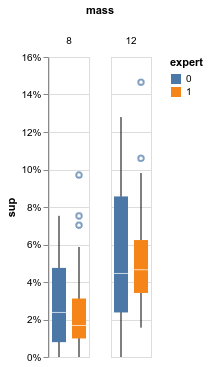

In [12]:
alt.Chart(sup).mark_boxplot().encode(
    alt.X(
        "expert:N", axis=alt.Axis(ticks=False, labels=False, domain=False), title=None
    ),
    alt.Y("sup", axis=alt.Axis(format="%")),
    alt.Color("expert:N"),
).facet(column="mass")

In [13]:
sup.head()

,filename,expert,mass,sup
0,antc_1_r08_1,0,8,0.000000
1,antc_1_r08_4,0,8,0.004950
2,antc_1_r08_5,0,8,0.000000
3,antc_1_r08_6,0,8,0.000000
4,antc_1_r12_1,0,12,0.031683


# Density

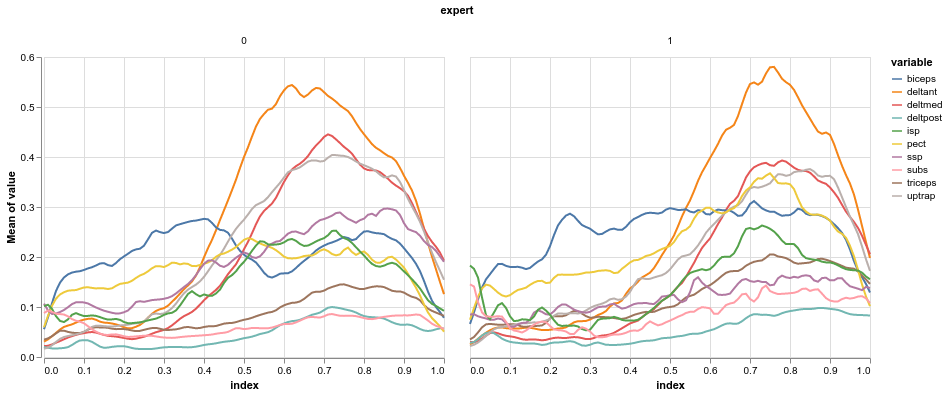

In [16]:
alt.Chart(emg_melt).mark_line().encode(
    alt.X("index"), alt.Y("mean(value)"), alt.Color("variable")
).facet(column="expert")

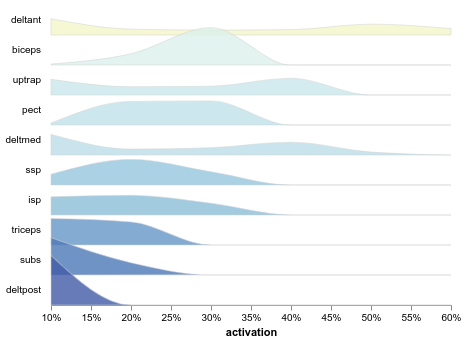

In [18]:
ridge_plot(
    emg_melt.groupby(["variable", "index"])["value"].mean().reset_index(),
    value="value",
    groupby="variable",
    sort=emg_melt.groupby(["variable"])["value"]
    .mean()
    .sort_values(ascending=False)
    .index.to_list(),
)

# $\sum$activation

In [19]:
sum_emg = emg_melt.groupby(id_vars)["value"].sum().reset_index()
sum_emg.head()

,filename,participant,expert,mass,index,value
0,antc_1_r08_1,antc,0,8,0.00,0.529756
1,antc_1_r08_1,antc,0,8,0.01,0.513532
2,antc_1_r08_1,antc,0,8,0.02,0.415259
3,antc_1_r08_1,antc,0,8,0.03,0.298507
4,antc_1_r08_1,antc,0,8,0.04,0.231019


In [20]:
y = (
    sum_emg.assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index(id_vars)
    .unstack()
)
y.head()

value                                \
index                                     0.00      0.01      0.02      0.03   
filename     participant expert mass                                           
antc_1_r08_1 1           0      8     0.529756  0.513532  0.415259  0.298507   
antc_1_r08_4 1           0      8     0.308204  0.263331  0.279650  0.318067   
antc_1_r08_5 1           0      8     0.417872  0.418810  0.437132  0.481030   
antc_1_r08_6 1           0      8     0.317155  0.289386  0.280905  0.291472   
antc_1_r12_1 1           0      12    0.372705  0.434266  0.532651  0.610229   

                                                                              \
index                                     0.04      0.05      0.06      0.07   
filename     participant expert mass                                           
antc_1_r08_1 1           0      8     0.231019  0.240957  0.313181  0.403670   
antc_1_r08_4 1           0      8     0.362703  0.413131  0.462687  0.505416   
antc_1_r08_5 1           0      8     0.547856  0.615175  0.653780  0.646633   
antc_1_r08_6 1           0      8     0.322813  0.376758  0.451720  0.539705   
antc_1_r12_1 1           0      12    0.681019  0.618112  0.392741  0.242655   

                                                          ...            \
index                                     0.08      0.09  ...      0.91   
filename     participant expert mass                      ...             
antc_1_r08_1 1           0      8     0.464460  0.477457  ...  0.763334   
antc_1_r08_4 1           0      8     0.556896  0.633971  ...  0.970805   
antc_1_r08_5 1           0      8     0.603848  0.564065  ...  0.956656   
antc_1_r08_6 1           0      8     0.625429  0.689279  ...  2.048469   
antc_1_r12_1 1           0      12    0.261785  0.347030  ...  1.254896   

                                                                              \
index                                     0.92      0.93      0.94      0.95   
filename     participant expert mass                                           
antc_1_r08_1 1           0      8     0.651653  0.578676  0.585276  0.651079   
antc_1_r08_4 1           0      8     0.859744  0.714135  0.583430  0.495252   
antc_1_r08_5 1           0      8     0.966032  0.989136  0.978956  0.906457   
antc_1_r08_6 1           0      8     2.091239  2.002800  1.814361  1.602384   
antc_1_r12_1 1           0      12    1.018513  0.862451  0.829816  0.846201   

                                                                              \
index                                     0.96      0.97      0.98      0.99   
filename     participant expert mass                                           
antc_1_r08_1 1           0      8     0.716623  0.723611  0.651612  0.535301   
antc_1_r08_4 1           0      8     0.455787  0.440009  0.411988  0.375478   
antc_1_r08_5 1           0      8     0.785357  0.652379  0.554485  0.515579   
antc_1_r08_6 1           0      8     1.453892  1.424895  1.516101  1.678774   
antc_1_r12_1 1           0      12    0.803277  0.676807  0.574135  0.521084   

                                                
index                                     1.00  
filename     participant expert mass            
antc_1_r08_1 1           0      8     0.436590  
antc_1_r08_4 1           0      8     0.363623  
antc_1_r08_5 1           0      8     0.508947  
antc_1_r08_6 1           0      8     1.844769  
antc_1_r12_1 1           0      12    0.468204  

[5 rows x 101 columns]

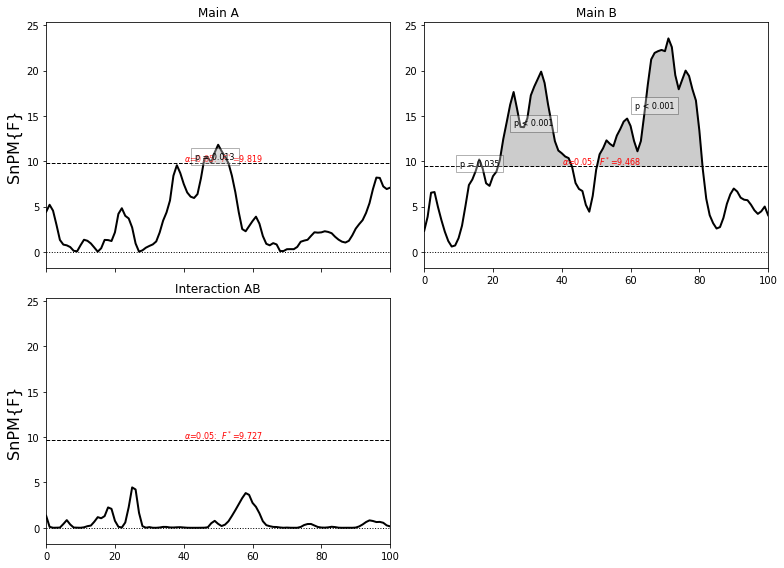

In [21]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(),
    A=y.index.get_level_values("expert"),
    B=y.index.get_level_values("mass"),
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [22]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main expertise",
        "Main B": "main mass",
        "Interaction AB": "interaction expertise-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main expertise,0.013,0.453236,0.524424
1,main mass,0.0353333,0.152654,0.165746
2,main mass,0.000333333,0.212623,0.424864
3,main mass,0.000333333,0.497367,0.801139


In [23]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

In [29]:
base = alt.Chart(sum_emg).encode(
    alt.X("index", title="normalized trial", axis=alt.Axis(format="%"))
)
mu = base.mark_line().encode(alt.Y("mean(value)", title="Σ activation"))
sigma = base.mark_errorband(extent="stdev").encode(alt.Y("value", title=None))
men_scale = alt.Scale(scheme="set1")

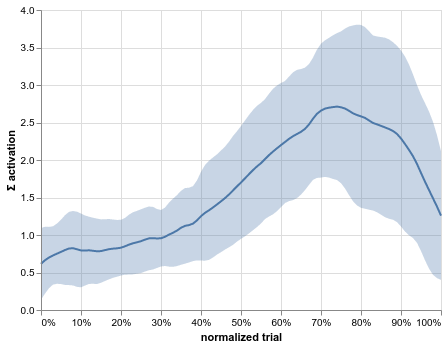

In [30]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

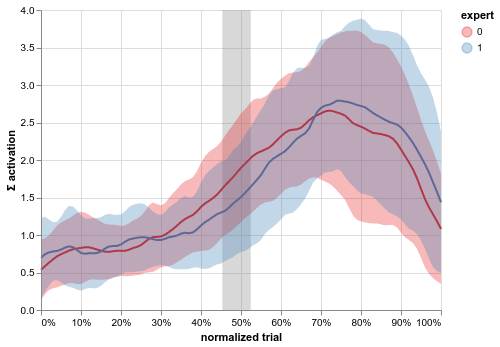

In [31]:
c.transform_filter('datum.effect == "main expertise"') + (mu + sigma).encode(
    alt.Color("expert:N", scale=men_scale)
)

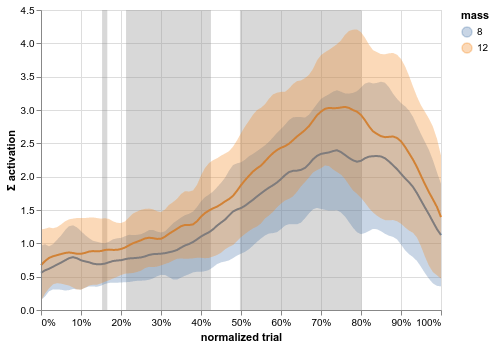

In [27]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

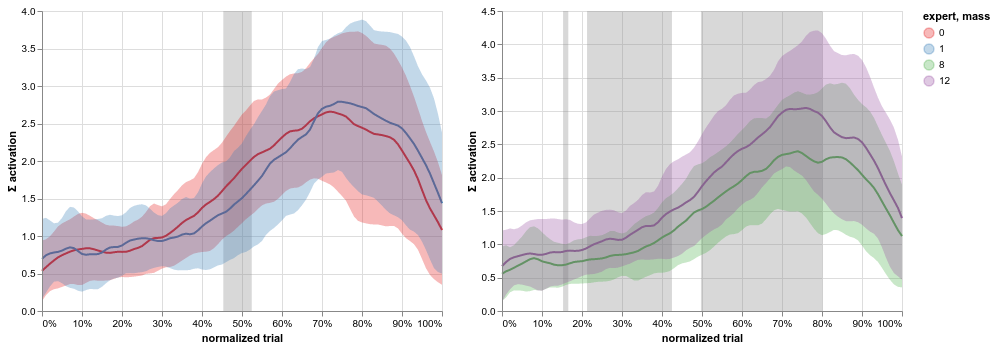

In [32]:
c.transform_filter('datum.effect == "main expertise"') + (mu + sigma).encode(
    alt.Color("expert:N", scale=men_scale)
) | c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

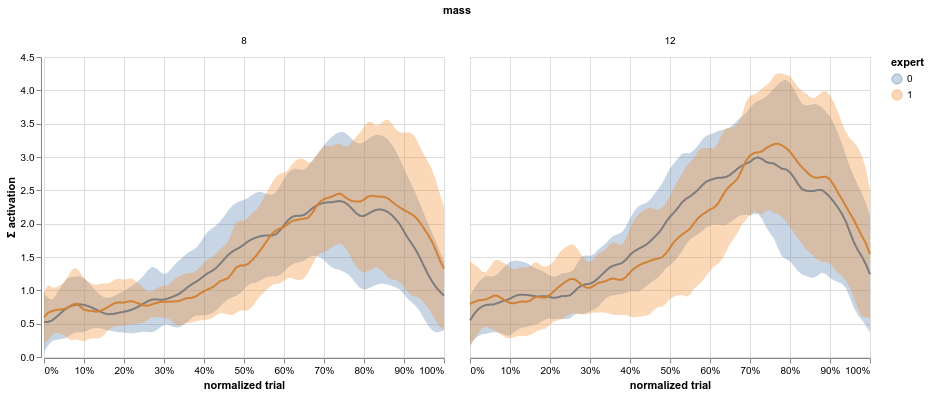

In [33]:
(mu + sigma).encode(alt.Color("expert:N")).facet(column="mass")

## ECDF

### ECDF on activations

In [34]:
emg_melt["ecdf"] = emg_melt.groupby("filename")["value"].transform(
    lambda x: x.rank(method="first") / x.shape[0]
)

In [36]:
target_col_shape = 100

y = (
    emg_melt.drop(["index", "variable"], axis=1)
    .assign(participant=lambda x: x["participant"].astype("category").cat.codes)
    .set_index([i if i != "index" else "ecdf" for i in id_vars])
    .unstack()
)
y = y.iloc[:, 0 :: int(y.shape[1] / target_col_shape)]
y.head()

value                                \
ecdf                                  0.000990  0.010891  0.020792  0.030693   
filename     participant expert mass                                           
antc_1_r08_1 1           0      8     0.003945  0.009870  0.011705  0.012901   
antc_1_r08_4 1           0      8     0.008263  0.011983  0.013476  0.014855   
antc_1_r08_5 1           0      8     0.009649  0.012421  0.013695  0.016331   
antc_1_r08_6 1           0      8     0.006534  0.012129  0.013075  0.013597   
antc_1_r12_1 1           0      12    0.000000  0.009819  0.015207  0.018874   

                                                                              \
ecdf                                  0.040594  0.050495  0.060396  0.070297   
filename     participant expert mass                                           
antc_1_r08_1 1           0      8     0.014402  0.015114  0.015921  0.016717   
antc_1_r08_4 1           0      8     0.017317  0.018653  0.020106  0.021983   
antc_1_r08_5 1           0      8     0.020397  0.022596  0.023597  0.024248   
antc_1_r08_6 1           0      8     0.014313  0.014825  0.015521  0.016262   
antc_1_r12_1 1           0      12    0.020838  0.022133  0.024422  0.026408   

                                                          ...            \
ecdf                                  0.080198  0.090099  ...  0.901980   
filename     participant expert mass                      ...             
antc_1_r08_1 1           0      8     0.017647  0.018658  ...  0.193934   
antc_1_r08_4 1           0      8     0.024308  0.025482  ...  0.261878   
antc_1_r08_5 1           0      8     0.025591  0.026096  ...  0.268854   
antc_1_r08_6 1           0      8     0.017191  0.018420  ...  0.196160   
antc_1_r12_1 1           0      12    0.027229  0.028112  ...  0.442850   

                                                                              \
ecdf                                  0.911881  0.921782  0.931683  0.941584   
filename     participant expert mass                                           
antc_1_r08_1 1           0      8     0.199966  0.207662  0.219309  0.230260   
antc_1_r08_4 1           0      8     0.271578  0.295636  0.309418  0.333378   
antc_1_r08_5 1           0      8     0.290587  0.308298  0.333680  0.352512   
antc_1_r08_6 1           0      8     0.200758  0.204991  0.213882  0.221358   
antc_1_r12_1 1           0      12    0.466365  0.496907  0.515427  0.531528   

                                                                              \
ecdf                                  0.951485  0.961386  0.971287  0.981188   
filename     participant expert mass                                           
antc_1_r08_1 1           0      8     0.252054  0.268988  0.303323  0.319151   
antc_1_r08_4 1           0      8     0.344696  0.400398  0.428421  0.462900   
antc_1_r08_5 1           0      8     0.383215  0.414179  0.434039  0.471065   
antc_1_r08_6 1           0      8     0.230754  0.245143  0.253824  0.280303   
antc_1_r12_1 1           0      12    0.554619  0.574430  0.613764  0.628304   

                                                
ecdf                                  0.991089  
filename     participant expert mass            
antc_1_r08_1 1           0      8     0.360092  
antc_1_r08_4 1           0      8     0.529899  
antc_1_r08_5 1           0      8     0.518103  
antc_1_r08_6 1           0      8     0.329989  
antc_1_r12_1 1           0      12    0.684856  

[5 rows x 101 columns]

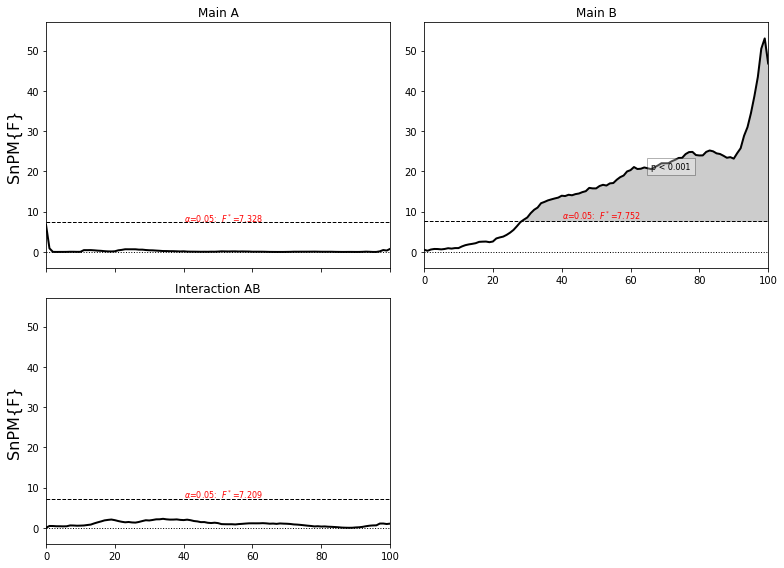

In [37]:
α = 0.05
n_iter = 1000
spm = spm1d.stats.nonparam.anova2(
    y.to_numpy(),
    A=y.index.get_level_values("expert"),
    B=y.index.get_level_values("mass"),
)
spmi = spm.inference(alpha=α, iterations=n_iter)

plt.figure(figsize=(11, 8))
spmi.plot()
plt.tight_layout()

In [39]:
clusters = get_spm_cluster(
    spmi,
    labels={
        "Main A": "main expertise",
        "Main B": "main mass",
        "Interaction AB": "interaction expertise-mass",
    },
    mult=1 / y.shape[1],
)
clusters

,effect,p,start,end
0,main mass,0,0.282851,0.990099


In [45]:
c = (
    alt.Chart(clusters)
    .mark_rect(opacity=0.3, color="grey")
    .encode(alt.X("start"), alt.X2("end"))
)

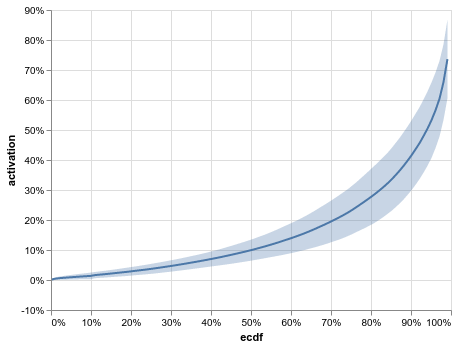

In [46]:
(mu + sigma)  # + c.encode(alt.Color("effect"))

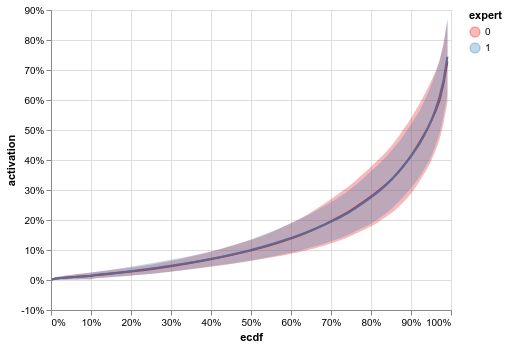

In [47]:
c.transform_filter('datum.effect == "main expertise"') + (mu + sigma).encode(
    alt.Color("expert:N", scale=men_scale)
)

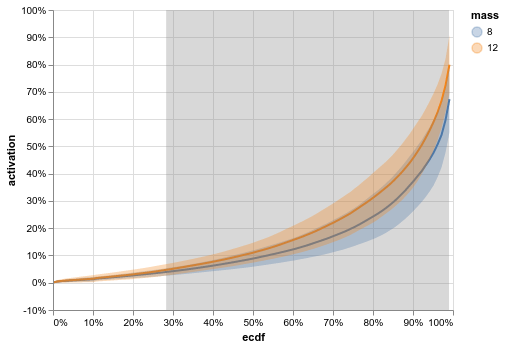

In [48]:
c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

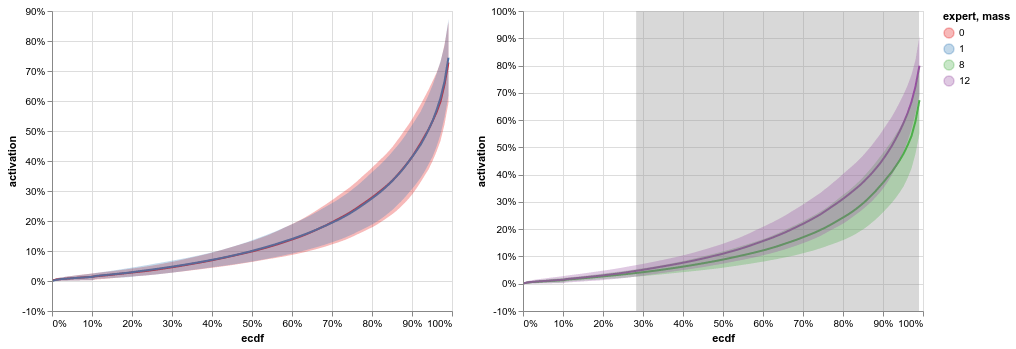

In [49]:
c.transform_filter('datum.effect == "main expertise"') + (mu + sigma).encode(
    alt.Color("expert:N", scale=men_scale)
) | c.transform_filter('datum.effect == "main mass"') + (mu + sigma).encode(
    alt.Color("mass:N")
)

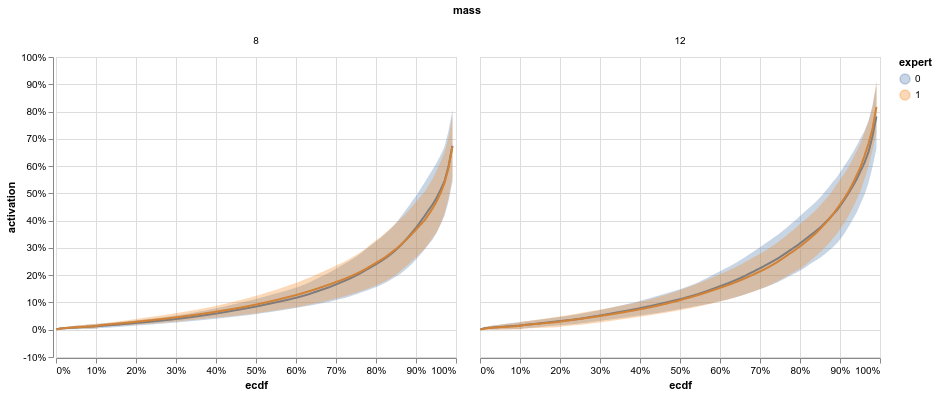

In [50]:
(mu + sigma).encode(alt.Color("expert:N")).facet(column="mass")

## $\sum\sum\text{activations}$

In [51]:
sum_sum_emg = (
    sum_emg.groupby([i for i in id_vars if i != "index"])["value"].sum().reset_index()
)
sum_sum_emg.head()

,filename,participant,expert,mass,value
0,antc_1_r08_1,antc,0,8,87.560021
1,antc_1_r08_4,antc,0,8,118.291427
2,antc_1_r08_5,antc,0,8,126.559236
3,antc_1_r08_6,antc,0,8,85.695669
4,antc_1_r12_1,antc,0,12,181.637031


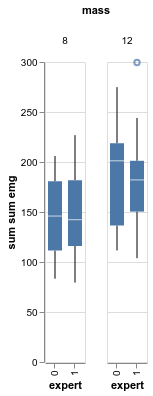

In [52]:
alt.Chart().mark_boxplot().encode(
    alt.X("expert:N"), alt.Y("value", title="sum sum emg")
).facet(data=sum_sum_emg, column=alt.Column("mass"))

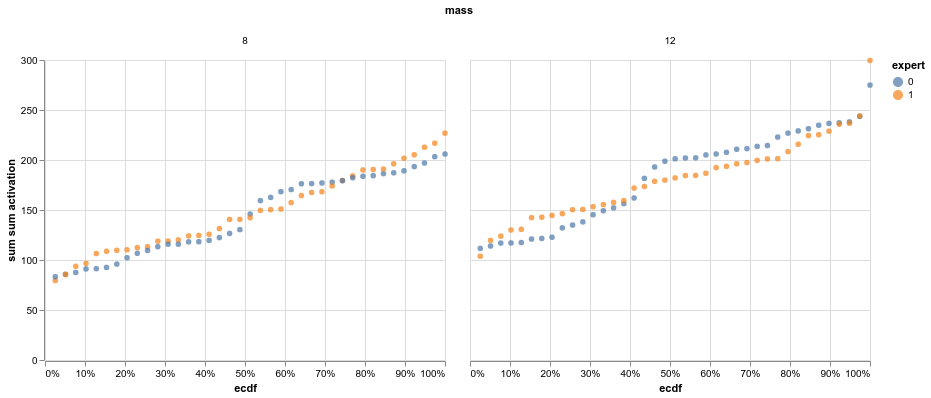

In [53]:
alt.Chart(
    sum_sum_emg.assign(
        ecdf=lambda x: x.groupby(["expert", "mass"])["value"].transform(
            lambda x: x.rank(method="first") / x.shape[0]
        )
    )
).mark_circle().encode(
    alt.X("ecdf", axis=alt.Axis(format="%")),
    alt.Y("value", title="sum sum activation"),
    alt.Color("expert:N"),
    alt.Column("mass"),
)

<!--NAVIGATION-->
< [Joint contribution](03.01-contributions-evsn.ipynb) | [Contents](Index.ipynb) | [Muscle activations & muscles forces](03.03-muscle-activations-forces.ipynb) >